In [32]:
# %%
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %%
import torch
import supervision as sv
import pytorch_lightning as pl
import cv2
from torch.utils.data import DataLoader, random_split

# %%
from transformers import DetrImageProcessor, DetrForObjectDetection

# %%
import os
from pathlib import Path
import json
from PIL import Image

In [33]:
CSV_PATH = Path("../data/train_solution_bounding_boxes.csv")
TRAIN_IMAGE_DIR = Path('../data/training_images')
OUTPUT_TRAIN_JSON_PATH = os.path.join(TRAIN_IMAGE_DIR, 'annotations_coco.json')
ANNOTATION_FILE_NAME = 'annotations_coco.json'


In [34]:
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [35]:
# Training config
VALIDATION_SPLIT = 0.2  # 20% for validation
BATCH_SIZE = 2
MAX_EPOCHS = 20

In [36]:
# Prepare coco format
coco = {
    "images": [],
    "annotations": [],
    "categories": [
        {
            "id": 1,
            "name": "car",
            "supercategory": "vehicle"
        }
    ]
}


In [37]:
train = pd.read_csv(CSV_PATH)

In [38]:
import torchvision
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(TRAIN_IMAGE_DIR, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(TRAIN_IMAGE_DIR, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {
            "image_id": image_id,
            "annotations": annotations
        }
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors = 'pt')
        pixel_values = encoding['pixel_values'].squeeze()
        target = encoding['labels'][0]
        return pixel_values, target

In [39]:
# Create full dataset
FULL_DATASET = CocoDetection(
    image_directory_path = TRAIN_IMAGE_DIR,
    image_processor=image_processor,
    train = True
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [40]:
# Split dataset into train and validation
train_size = int((1 - VALIDATION_SPLIT) * len(FULL_DATASET))
val_size = len(FULL_DATASET) - train_size

train_dataset, val_dataset = random_split(
    FULL_DATASET,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducible splits
)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

Train dataset size: 284
Validation dataset size: 71


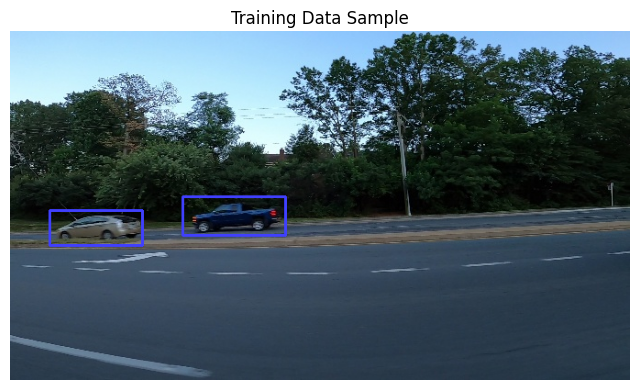

In [41]:
# Visualize a sample from training data
image_ids = FULL_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
image_info = FULL_DATASET.coco.loadImgs(image_id)[0]
annotations = FULL_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(FULL_DATASET.root, image_info['file_name'])

image = cv2.imread(image_path)
if image is None:
    print(f"[ERROR] Failed to load image: {image_path}")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    xyxy = []
    class_ids = []

    for ann in annotations:
        x, y, w, h = ann['bbox']
        xyxy.append([x, y, x + w, y + h])
        class_ids.append(ann['category_id'])

    categories = FULL_DATASET.coco.cats
    id2label = {k: v['name'] for k, v in categories.items()}
    labels = [id2label[cid] for cid in class_ids]

    detections = sv.Detections(
        xyxy=np.array(xyxy, dtype=np.float32),
        class_id=np.array(class_ids),
        data={"label": labels}
    )

    box_annotator = sv.BoxAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)

    plt.figure(figsize=(8, 8))
    plt.imshow(annotated_image)
    plt.axis("off")
    plt.title("Training Data Sample")
    plt.show()

In [42]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors = 'pt')
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }


In [43]:
# Create separate dataloaders for train and validation
TRAIN_DATALOADER = DataLoader(
    dataset=train_dataset,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    shuffle=True
)

VAL_DATALOADER = DataLoader(
    dataset=val_dataset,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [44]:
print(f'Train batches: {len(TRAIN_DATALOADER)}')
print(f'Validation batches: {len(VAL_DATALOADER)}')

Train batches: 142
Validation batches: 36


In [45]:
class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50",
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

        # Store losses for plotting
        self.train_losses = []
        self.val_losses = []

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)

        # Log training metrics
        self.log("train_loss", loss, prog_bar=True)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        # Store loss for plotting
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)

        # Log validation metrics
        self.log("val_loss", loss, prog_bar=True)
        for k, v in loss_dict.items():
            self.log("val_" + k, v.item())

        # Store loss for plotting
        self.val_losses.append(loss.item())
        return loss

    def on_validation_epoch_end(self):
        # Calculate and log average losses
        if len(self.train_losses) > 0:
            avg_train_loss = np.mean(self.train_losses[-len(VAL_DATALOADER):])  # Average over last validation batch count
            self.log("avg_train_loss", avg_train_loss)

        if len(self.val_losses) > 0:
            avg_val_loss = np.mean(self.val_losses[-len(VAL_DATALOADER):])
            self.log("avg_val_loss", avg_val_loss)

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [46]:
model = Detr(lr=1e-4,
             lr_backbone=1e-5,
             weight_decay=1e-4)

# Test the model with a batch
batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])
print("Model test successful!")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Model test successful!


In [47]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [48]:
# Set up callbacks for better training
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='detr-{epoch:02d}-{val_loss:.3f}',
    save_top_k=3,
    mode='min',
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=True
)

In [49]:
# Initialize trainer with validation
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    gradient_clip_val=0.1,
    accumulate_grad_batches=8,
    log_every_n_steps=5,
    callbacks=[checkpoint_callback, early_stopping],
    check_val_every_n_epoch=1,  # Validate every epoch
)

# Train the model
trainer.fit(model)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/abilfad/Documents/code/cv_task_pnu/cv_task/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/abilfad/Documents/code/cv_task_pnu/modeling/object_detection/iter_2/checkpoints exists and is not empty.

  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.007   Total estimated model params size (MB)
0         Modules in train mode
399       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/abilfad/Documents/code/cv_task_pnu/cv_task/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/abilfad/Documents/code/cv_task_pnu/cv_task/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/Users/abilfad/Documents/code/cv_task_pnu/cv_task/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/abilfad/Documents/code/cv_task_pnu/cv_task/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val_loss improved. New best score: 0.485


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.439


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.434


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.374


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.352


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.348


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.345


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.333


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [50]:
def plot_training_curves(model):
    """Plot training and validation loss curves"""

    # Get losses (taking every nth value to align with validation frequency)
    train_losses = model.train_losses
    val_losses = model.val_losses

    # Create epochs array
    train_epochs = np.arange(len(train_losses))
    val_epochs = np.arange(0, len(train_losses), len(train_losses)//len(val_losses))[:len(val_losses)]

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_epochs, train_losses, label='Training Loss', alpha=0.7)
    plt.plot(val_epochs, val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot smoothed losses
    plt.subplot(1, 2, 2)
    window_size = min(50, len(train_losses)//10)
    if window_size > 1:
        train_smooth = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
        plt.plot(train_smooth, label=f'Training Loss (smoothed, window={window_size})')
    plt.plot(val_epochs, val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Smoothed Training Curves')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Best Validation Loss: {min(val_losses):.4f}")



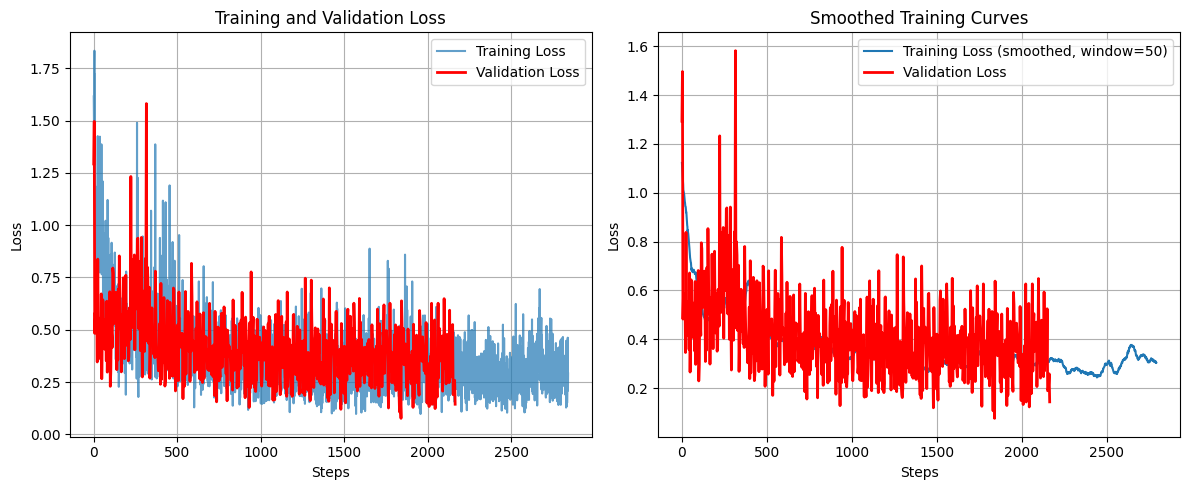

Final Training Loss: 0.2909
Final Validation Loss: 0.1438
Best Validation Loss: 0.0762


In [51]:
# Plot the training curves
plot_training_curves(model)

In [52]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = 'car-object-detection-detr-finetuned-with-validation-iter-2'

# Save the trained model
model.model.save_pretrained(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to car-object-detection-detr-finetuned-with-validation-iter-2


In [53]:
trained_model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
trained_model.to(DEVICE)
trained_model.eval()

print("Model ready for inference!")

Model ready for inference!


In [54]:
def evaluate_on_validation_set(model, val_dataloader, device, confidence_threshold=0.5):
    """Evaluate model performance on validation set"""
    model.eval()

    total_detections = 0
    total_images = 0
    total_loss = 0

    image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            pixel_values = batch["pixel_values"].to(device)
            pixel_mask = batch["pixel_mask"].to(device)
            labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

            # Forward pass
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

            # Accumulate loss
            total_loss += outputs.loss.item()

            # Count detections (simplified metric)
            for i in range(len(outputs.logits)):
                # Get predictions above confidence threshold
                probs = outputs.logits[i].softmax(-1)
                keep = probs.max(-1).values > confidence_threshold
                total_detections += keep.sum().item()

            total_images += len(outputs.logits)

            if batch_idx % 10 == 0:
                print(f"Processed {batch_idx}/{len(val_dataloader)} validation batches")

    avg_loss = total_loss / len(val_dataloader)
    avg_detections_per_image = total_detections / total_images

    print(f"\nValidation Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average Detections per Image: {avg_detections_per_image:.2f}")
    print(f"Total Images Evaluated: {total_images}")

    return avg_loss, avg_detections_per_image

In [55]:
# Evaluate the trained model
eval_loss, eval_detections = evaluate_on_validation_set(trained_model, VAL_DATALOADER, DEVICE)

Processed 0/36 validation batches
Processed 10/36 validation batches
Processed 20/36 validation batches
Processed 30/36 validation batches

Validation Results:
Average Loss: 0.3692
Average Detections per Image: 100.00
Total Images Evaluated: 71
